## RandAugment Implementation for Generating Datasets

#### Citation: 
Ekin D. Cubuk, Barret Zoph, Jonathon Shlens, & Quoc V. Le. (2019). RandAugment: Practical automated data augmentation with a reduced search space.

#### Import Libraries

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from PIL import Image
import IPython.display as display
import io
import os
import datetime
import logging
import glob
import boto3

#### Download the CIFAR10 dataset

In [2]:
# load dataset
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_x.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_x.shape, test_y.shape))

170500096/170498071 [==============================] - 3s 0us/step: 
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


#### Functions that implement RandAugment

In [5]:
# Copyright 2019 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""AutoAugment and RandAugment policies for enhanced image preprocessing.
AutoAugment Reference: https://arxiv.org/abs/1805.09501
RandAugment Reference: https://arxiv.org/abs/1909.13719
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import inspect
import math
import tensorflow.compat.v1 as tf
from tensorflow.contrib import image as contrib_image
from tensorflow.contrib import training as contrib_training


# This signifies the max integer that the controller RNN could predict for the
# augmentation scheme.
_MAX_LEVEL = 10.


def policy_v0():
  """Autoaugment policy that was used in AutoAugment Paper."""
  # Each tuple is an augmentation operation of the form
  # (operation, probability, magnitude). Each element in policy is a
  # sub-policy that will be applied sequentially on the image.
  policy = [
      [('Equalize', 0.8, 1), ('ShearY', 0.8, 4)],
      [('Color', 0.4, 9), ('Equalize', 0.6, 3)],
      [('Color', 0.4, 1), ('Rotate', 0.6, 8)],
      [('Solarize', 0.8, 3), ('Equalize', 0.4, 7)],
      [('Solarize', 0.4, 2), ('Solarize', 0.6, 2)],
      [('Color', 0.2, 0), ('Equalize', 0.8, 8)],
      [('Equalize', 0.4, 8), ('SolarizeAdd', 0.8, 3)],
      [('ShearX', 0.2, 9), ('Rotate', 0.6, 8)],
      [('Color', 0.6, 1), ('Equalize', 1.0, 2)],
      [('Invert', 0.4, 9), ('Rotate', 0.6, 0)],
      [('Equalize', 1.0, 9), ('ShearY', 0.6, 3)],
      [('Color', 0.4, 7), ('Equalize', 0.6, 0)],
      [('Posterize', 0.4, 6), ('AutoContrast', 0.4, 7)],
      [('Solarize', 0.6, 8), ('Color', 0.6, 9)],
      [('Solarize', 0.2, 4), ('Rotate', 0.8, 9)],
      [('Rotate', 1.0, 7), ('TranslateY', 0.8, 9)],
      [('ShearX', 0.0, 0), ('Solarize', 0.8, 4)],
      [('ShearY', 0.8, 0), ('Color', 0.6, 4)],
      [('Color', 1.0, 0), ('Rotate', 0.6, 2)],
      [('Equalize', 0.8, 4), ('Equalize', 0.0, 8)],
      [('Equalize', 1.0, 4), ('AutoContrast', 0.6, 2)],
      [('ShearY', 0.4, 7), ('SolarizeAdd', 0.6, 7)],
      [('Posterize', 0.8, 2), ('Solarize', 0.6, 10)],
      [('Solarize', 0.6, 8), ('Equalize', 0.6, 1)],
      [('Color', 0.8, 6), ('Rotate', 0.4, 5)],
  ]
  return policy


def policy_vtest():
  """Autoaugment test policy for debugging."""
  # Each tuple is an augmentation operation of the form
  # (operation, probability, magnitude). Each element in policy is a
  # sub-policy that will be applied sequentially on the image.
  policy = [
      [('TranslateX', 1.0, 4), ('Equalize', 1.0, 10)],
  ]
  return policy


def blend(image1, image2, factor):
  """Blend image1 and image2 using 'factor'.
  Factor can be above 0.0.  A value of 0.0 means only image1 is used.
  A value of 1.0 means only image2 is used.  A value between 0.0 and
  1.0 means we linearly interpolate the pixel values between the two
  images.  A value greater than 1.0 "extrapolates" the difference
  between the two pixel values, and we clip the results to values
  between 0 and 255.
  Args:
    image1: An image Tensor of type uint8.
    image2: An image Tensor of type uint8.
    factor: A floating point value above 0.0.
  Returns:
    A blended image Tensor of type uint8.
  """
  if factor == 0.0:
    return tf.convert_to_tensor(image1)
  if factor == 1.0:
    return tf.convert_to_tensor(image2)

  image1 = tf.to_float(image1)
  image2 = tf.to_float(image2)

  difference = image2 - image1
  scaled = factor * difference

  # Do addition in float.
  temp = tf.to_float(image1) + scaled

  # Interpolate
  if factor > 0.0 and factor < 1.0:
    # Interpolation means we always stay within 0 and 255.
    return tf.cast(temp, tf.uint8)

  # Extrapolate:
  #
  # We need to clip and then cast.
  return tf.cast(tf.clip_by_value(temp, 0.0, 255.0), tf.uint8)


def cutout(image, pad_size, replace=0):
  """Apply cutout (https://arxiv.org/abs/1708.04552) to image.
  This operation applies a (2*pad_size x 2*pad_size) mask of zeros to
  a random location within `img`. The pixel values filled in will be of the
  value `replace`. The located where the mask will be applied is randomly
  chosen uniformly over the whole image.
  Args:
    image: An image Tensor of type uint8.
    pad_size: Specifies how big the zero mask that will be generated is that
      is applied to the image. The mask will be of size
      (2*pad_size x 2*pad_size).
    replace: What pixel value to fill in the image in the area that has
      the cutout mask applied to it.
  Returns:
    An image Tensor that is of type uint8.
  """
  image_height = tf.shape(image)[0]
  image_width = tf.shape(image)[1]

  # Sample the center location in the image where the zero mask will be applied.
  cutout_center_height = tf.random_uniform(
      shape=[], minval=0, maxval=image_height,
      dtype=tf.int32)

  cutout_center_width = tf.random_uniform(
      shape=[], minval=0, maxval=image_width,
      dtype=tf.int32)

  lower_pad = tf.maximum(0, cutout_center_height - pad_size)
  upper_pad = tf.maximum(0, image_height - cutout_center_height - pad_size)
  left_pad = tf.maximum(0, cutout_center_width - pad_size)
  right_pad = tf.maximum(0, image_width - cutout_center_width - pad_size)

  cutout_shape = [image_height - (lower_pad + upper_pad),
                  image_width - (left_pad + right_pad)]
  padding_dims = [[lower_pad, upper_pad], [left_pad, right_pad]]
  mask = tf.pad(
      tf.zeros(cutout_shape, dtype=image.dtype),
      padding_dims, constant_values=1)
  mask = tf.expand_dims(mask, -1)
  mask = tf.tile(mask, [1, 1, 3])
  image = tf.where(
      tf.equal(mask, 0),
      tf.ones_like(image, dtype=image.dtype) * replace,
      image)
  return image


def solarize(image, threshold=128):
  # For each pixel in the image, select the pixel
  # if the value is less than the threshold.
  # Otherwise, subtract 255 from the pixel.
  return tf.where(image < threshold, image, 255 - image)


def solarize_add(image, addition=0, threshold=128):
  # For each pixel in the image less than threshold
  # we add 'addition' amount to it and then clip the
  # pixel value to be between 0 and 255. The value
  # of 'addition' is between -128 and 128.
  added_image = tf.cast(image, tf.int64) + addition
  added_image = tf.cast(tf.clip_by_value(added_image, 0, 255), tf.uint8)
  return tf.where(image < threshold, added_image, image)


def color(image, factor):
  """Equivalent of PIL Color."""
  degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
  return blend(degenerate, image, factor)


def contrast(image, factor):
  """Equivalent of PIL Contrast."""
  degenerate = tf.image.rgb_to_grayscale(image)
  # Cast before calling tf.histogram.
  degenerate = tf.cast(degenerate, tf.int32)

  # Compute the grayscale histogram, then compute the mean pixel value,
  # and create a constant image size of that value.  Use that as the
  # blending degenerate target of the original image.
  hist = tf.histogram_fixed_width(degenerate, [0, 255], nbins=256)
  mean = tf.reduce_sum(tf.cast(hist, tf.float32)) / 256.0
  degenerate = tf.ones_like(degenerate, dtype=tf.float32) * mean
  degenerate = tf.clip_by_value(degenerate, 0.0, 255.0)
  degenerate = tf.image.grayscale_to_rgb(tf.cast(degenerate, tf.uint8))
  return blend(degenerate, image, factor)


def brightness(image, factor):
  """Equivalent of PIL Brightness."""
  degenerate = tf.zeros_like(image)
  return blend(degenerate, image, factor)


def posterize(image, bits):
  """Equivalent of PIL Posterize."""
  shift = 8 - bits
  return tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)


def rotate(image, degrees, replace):
  """Rotates the image by degrees either clockwise or counterclockwise.
  Args:
    image: An image Tensor of type uint8.
    degrees: Float, a scalar angle in degrees to rotate all images by. If
      degrees is positive the image will be rotated clockwise otherwise it will
      be rotated counterclockwise.
    replace: A one or three value 1D tensor to fill empty pixels caused by
      the rotate operation.
  Returns:
    The rotated version of image.
  """
  # Convert from degrees to radians.
  degrees_to_radians = math.pi / 180.0
  radians = degrees * degrees_to_radians

  # In practice, we should randomize the rotation degrees by flipping
  # it negatively half the time, but that's done on 'degrees' outside
  # of the function.
  image = contrib_image.rotate(wrap(image), radians)
  return unwrap(image, replace)


def translate_x(image, pixels, replace):
  """Equivalent of PIL Translate in X dimension."""
  image = contrib_image.translate(wrap(image), [-pixels, 0])
  return unwrap(image, replace)


def translate_y(image, pixels, replace):
  """Equivalent of PIL Translate in Y dimension."""
  image = contrib_image.translate(wrap(image), [0, -pixels])
  return unwrap(image, replace)


def shear_x(image, level, replace):
  """Equivalent of PIL Shearing in X dimension."""
  # Shear parallel to x axis is a projective transform
  # with a matrix form of:
  # [1  level
  #  0  1].
  image = contrib_image.transform(
      wrap(image), [1., level, 0., 0., 1., 0., 0., 0.])
  return unwrap(image, replace)


def shear_y(image, level, replace):
  """Equivalent of PIL Shearing in Y dimension."""
  # Shear parallel to y axis is a projective transform
  # with a matrix form of:
  # [1  0
  #  level  1].
  image = contrib_image.transform(
      wrap(image), [1., 0., 0., level, 1., 0., 0., 0.])
  return unwrap(image, replace)


def autocontrast(image):
  """Implements Autocontrast function from PIL using TF ops.
  Args:
    image: A 3D uint8 tensor.
  Returns:
    The image after it has had autocontrast applied to it and will be of type
    uint8.
  """

  def scale_channel(image):
    """Scale the 2D image using the autocontrast rule."""
    # A possibly cheaper version can be done using cumsum/unique_with_counts
    # over the histogram values, rather than iterating over the entire image.
    # to compute mins and maxes.
    lo = tf.to_float(tf.reduce_min(image))
    hi = tf.to_float(tf.reduce_max(image))

    # Scale the image, making the lowest value 0 and the highest value 255.
    def scale_values(im):
      scale = 255.0 / (hi - lo)
      offset = -lo * scale
      im = tf.to_float(im) * scale + offset
      im = tf.clip_by_value(im, 0.0, 255.0)
      return tf.cast(im, tf.uint8)

    result = tf.cond(hi > lo, lambda: scale_values(image), lambda: image)
    return result

  # Assumes RGB for now.  Scales each channel independently
  # and then stacks the result.
  s1 = scale_channel(image[:, :, 0])
  s2 = scale_channel(image[:, :, 1])
  s3 = scale_channel(image[:, :, 2])
  image = tf.stack([s1, s2, s3], 2)
  return image


def sharpness(image, factor):
  """Implements Sharpness function from PIL using TF ops."""
  orig_image = image
  image = tf.cast(image, tf.float32)
  # Make image 4D for conv operation.
  image = tf.expand_dims(image, 0)
  # SMOOTH PIL Kernel.
  kernel = tf.constant(
      [[1, 1, 1], [1, 5, 1], [1, 1, 1]], dtype=tf.float32,
      shape=[3, 3, 1, 1]) / 13.
  # Tile across channel dimension.
  kernel = tf.tile(kernel, [1, 1, 3, 1])
  strides = [1, 1, 1, 1]
  degenerate = tf.nn.depthwise_conv2d(
      image, kernel, strides, padding='VALID', rate=[1, 1])
  degenerate = tf.clip_by_value(degenerate, 0.0, 255.0)
  degenerate = tf.squeeze(tf.cast(degenerate, tf.uint8), [0])

  # For the borders of the resulting image, fill in the values of the
  # original image.
  mask = tf.ones_like(degenerate)
  padded_mask = tf.pad(mask, [[1, 1], [1, 1], [0, 0]])
  padded_degenerate = tf.pad(degenerate, [[1, 1], [1, 1], [0, 0]])
  result = tf.where(tf.equal(padded_mask, 1), padded_degenerate, orig_image)

  # Blend the final result.
  return blend(result, orig_image, factor)


def equalize(image):
  """Implements Equalize function from PIL using TF ops."""
  def scale_channel(im, c):
    """Scale the data in the channel to implement equalize."""
    im = tf.cast(im[:, :, c], tf.int32)
    # Compute the histogram of the image channel.
    histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)

    # For the purposes of computing the step, filter out the nonzeros.
    nonzero = tf.where(tf.not_equal(histo, 0))
    nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
    step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

    def build_lut(histo, step):
      # Compute the cumulative sum, shifting by step // 2
      # and then normalization by step.
      lut = (tf.cumsum(histo) + (step // 2)) // step
      # Shift lut, prepending with 0.
      lut = tf.concat([[0], lut[:-1]], 0)
      # Clip the counts to be in range.  This is done
      # in the C code for image.point.
      return tf.clip_by_value(lut, 0, 255)

    # If step is zero, return the original image.  Otherwise, build
    # lut from the full histogram and step and then index from it.
    result = tf.cond(tf.equal(step, 0),
                     lambda: im,
                     lambda: tf.gather(build_lut(histo, step), im))

    return tf.cast(result, tf.uint8)

  # Assumes RGB for now.  Scales each channel independently
  # and then stacks the result.
  s1 = scale_channel(image, 0)
  s2 = scale_channel(image, 1)
  s3 = scale_channel(image, 2)
  image = tf.stack([s1, s2, s3], 2)
  return image


def invert(image):
  """Inverts the image pixels."""
  image = tf.convert_to_tensor(image)
  return 255 - image

def wrap(image):
  """Returns 'image' with an extra channel set to all 1s."""
  shape = tf.shape(image)
  extended_channel = tf.ones([shape[0], shape[1], 1], image.dtype)
  extended = tf.concat([image, extended_channel], 2)
  return extended


def unwrap(image, replace):
  """Unwraps an image produced by wrap.
  Where there is a 0 in the last channel for every spatial position,
  the rest of the three channels in that spatial dimension are grayed
  (set to 128).  Operations like translate and shear on a wrapped
  Tensor will leave 0s in empty locations.  Some transformations look
  at the intensity of values to do preprocessing, and we want these
  empty pixels to assume the 'average' value, rather than pure black.
  Args:
    image: A 3D Image Tensor with 4 channels.
    replace: A one or three value 1D tensor to fill empty pixels.
  Returns:
    image: A 3D image Tensor with 3 channels.
  """
  image_shape = tf.shape(image)
  # Flatten the spatial dimensions.
  flattened_image = tf.reshape(image, [-1, image_shape[2]])

  # Find all pixels where the last channel is zero.
  alpha_channel = flattened_image[:, 3]

  replace = tf.concat([replace, tf.ones([1], image.dtype)], 0)

  # Where they are zero, fill them in with 'replace'.
  flattened_image = tf.where(
      tf.equal(alpha_channel, 0),
      tf.ones_like(flattened_image, dtype=image.dtype) * replace,
      flattened_image)

  image = tf.reshape(flattened_image, image_shape)
  image = tf.slice(image, [0, 0, 0], [image_shape[0], image_shape[1], 3])
  return image


NAME_TO_FUNC = {
    'AutoContrast': autocontrast,
    'Equalize': equalize,
    'Invert': invert,
    'Rotate': rotate,
    'Posterize': posterize,
    'Solarize': solarize,
    'SolarizeAdd': solarize_add,
    'Color': color,
    'Contrast': contrast,
    'Brightness': brightness,
    'Sharpness': sharpness,
    'ShearX': shear_x,
    'ShearY': shear_y,
    'TranslateX': translate_x,
    'TranslateY': translate_y,
    'Cutout': cutout,
}


def _randomly_negate_tensor(tensor):
  """With 50% prob turn the tensor negative."""
  should_flip = tf.cast(tf.floor(tf.random_uniform([]) + 0.5), tf.bool)
  final_tensor = tf.cond(should_flip, lambda: tensor, lambda: -tensor)
  return final_tensor


def _rotate_level_to_arg(level):
  level = (level/_MAX_LEVEL) * 30.
  level = _randomly_negate_tensor(level)
  return (level,)


def _shrink_level_to_arg(level):
  """Converts level to ratio by which we shrink the image content."""
  if level == 0:
    return (1.0,)  # if level is zero, do not shrink the image
  # Maximum shrinking ratio is 2.9.
  level = 2. / (_MAX_LEVEL / level) + 0.9
  return (level,)


def _enhance_level_to_arg(level):
  return ((level/_MAX_LEVEL) * 1.8 + 0.1,)


def _shear_level_to_arg(level):
  level = (level/_MAX_LEVEL) * 0.3
  # Flip level to negative with 50% chance.
  level = _randomly_negate_tensor(level)
  return (level,)


def _translate_level_to_arg(level, translate_const):
  level = (level/_MAX_LEVEL) * float(translate_const)
  # Flip level to negative with 50% chance.
  level = _randomly_negate_tensor(level)
  return (level,)


def level_to_arg(hparams):
  return {
      'AutoContrast': lambda level: (),
      'Equalize': lambda level: (),
      'Invert': lambda level: (),
      'Rotate': _rotate_level_to_arg,
      'Posterize': lambda level: (int((level/_MAX_LEVEL) * 4),),
      'Solarize': lambda level: (int((level/_MAX_LEVEL) * 256),),
      'SolarizeAdd': lambda level: (int((level/_MAX_LEVEL) * 110),),
      'Color': _enhance_level_to_arg,
      'Contrast': _enhance_level_to_arg,
      'Brightness': _enhance_level_to_arg,
      'Sharpness': _enhance_level_to_arg,
      'ShearX': _shear_level_to_arg,
      'ShearY': _shear_level_to_arg,
      'Cutout': lambda level: (int((level/_MAX_LEVEL) * hparams.cutout_const),),
      # pylint:disable=g-long-lambda
      'TranslateX': lambda level: _translate_level_to_arg(
          level, hparams.translate_const),
      'TranslateY': lambda level: _translate_level_to_arg(
          level, hparams.translate_const),
      # pylint:enable=g-long-lambda
  }


def _parse_policy_info(name, prob, level, replace_value, augmentation_hparams):
  """Return the function that corresponds to `name` and update `level` param."""
  func = NAME_TO_FUNC[name]
  args = level_to_arg(augmentation_hparams)[name](level)

  # Check to see if prob is passed into function. This is used for operations
  # where we alter bboxes independently.
  # pytype:disable=wrong-arg-types
  if 'prob' in inspect.getargspec(func)[0]:
    args = tuple([prob] + list(args))
  # pytype:enable=wrong-arg-types

  # Add in replace arg if it is required for the function that is being called.
  # pytype:disable=wrong-arg-types
  if 'replace' in inspect.getargspec(func)[0]:
    # Make sure replace is the final argument
    assert 'replace' == inspect.getargspec(func)[0][-1]
    args = tuple(list(args) + [replace_value])
  # pytype:enable=wrong-arg-types

  return (func, prob, args)


def _apply_func_with_prob(func, image, args, prob):
  """Apply `func` to image w/ `args` as input with probability `prob`."""
  assert isinstance(args, tuple)

  # If prob is a function argument, then this randomness is being handled
  # inside the function, so make sure it is always called.
  # pytype:disable=wrong-arg-types
  if 'prob' in inspect.getargspec(func)[0]:
    prob = 1.0
  # pytype:enable=wrong-arg-types

  # Apply the function with probability `prob`.
  should_apply_op = tf.cast(
      tf.floor(tf.random_uniform([], dtype=tf.float32) + prob), tf.bool)
  augmented_image = tf.cond(
      should_apply_op,
      lambda: func(image, *args),
      lambda: image)
  return augmented_image


def select_and_apply_random_policy(policies, image):
  """Select a random policy from `policies` and apply it to `image`."""
  policy_to_select = tf.random_uniform([], maxval=len(policies), dtype=tf.int32)
  # Note that using tf.case instead of tf.conds would result in significantly
  # larger graphs and would even break export for some larger policies.
  for (i, policy) in enumerate(policies):
    image = tf.cond(
        tf.equal(i, policy_to_select),
        lambda selected_policy=policy: selected_policy(image),
        lambda: image)
  return image


def build_and_apply_nas_policy(policies, image,
                               augmentation_hparams):
  """Build a policy from the given policies passed in and apply to image.
  Args:
    policies: list of lists of tuples in the form `(func, prob, level)`, `func`
      is a string name of the augmentation function, `prob` is the probability
      of applying the `func` operation, `level` is the input argument for
      `func`.
    image: tf.Tensor that the resulting policy will be applied to.
    augmentation_hparams: Hparams associated with the NAS learned policy.
  Returns:
    A version of image that now has data augmentation applied to it based on
    the `policies` pass into the function.
  """
  replace_value = [128, 128, 128]

  # func is the string name of the augmentation function, prob is the
  # probability of applying the operation and level is the parameter associated
  # with the tf op.

  # tf_policies are functions that take in an image and return an augmented
  # image.
  tf_policies = []
  for policy in policies:
    tf_policy = []
    # Link string name to the correct python function and make sure the correct
    # argument is passed into that function.
    for policy_info in policy:
      policy_info = list(policy_info) + [replace_value, augmentation_hparams]

      tf_policy.append(_parse_policy_info(*policy_info))
    # Now build the tf policy that will apply the augmentation procedue
    # on image.
    def make_final_policy(tf_policy_):
      def final_policy(image_):
        for func, prob, args in tf_policy_:
          image_ = _apply_func_with_prob(
              func, image_, args, prob)
        return image_
      return final_policy
    tf_policies.append(make_final_policy(tf_policy))

  augmented_image = select_and_apply_random_policy(
      tf_policies, image)
  return augmented_image


def distort_image_with_autoaugment(image, augmentation_name):
  """Applies the AutoAugment policy to `image`.
  AutoAugment is from the paper: https://arxiv.org/abs/1805.09501.
  Args:
    image: `Tensor` of shape [height, width, 3] representing an image.
    augmentation_name: The name of the AutoAugment policy to use. The available
      options are `v0` and `test`. `v0` is the policy used for
      all of the results in the paper and was found to achieve the best results
      on the COCO dataset. `v1`, `v2` and `v3` are additional good policies
      found on the COCO dataset that have slight variation in what operations
      were used during the search procedure along with how many operations are
      applied in parallel to a single image (2 vs 3).
  Returns:
    A tuple containing the augmented versions of `image`.
  """
  available_policies = {'v0': policy_v0,
                        'test': policy_vtest}
  if augmentation_name not in available_policies:
    raise ValueError('Invalid augmentation_name: {}'.format(augmentation_name))

  policy = available_policies[augmentation_name]()
  # Hparams that will be used for AutoAugment.
  augmentation_hparams = contrib_training.HParams(
      cutout_const=100, translate_const=250)

  return build_and_apply_nas_policy(policy, image, augmentation_hparams)


def distort_image_with_randaugment(image, num_layers, magnitude):
  """Applies the RandAugment policy to `image`.
  RandAugment is from the paper https://arxiv.org/abs/1909.13719,
  Args:
    image: `Tensor` of shape [height, width, 3] representing an image.
    num_layers: Integer, the number of augmentation transformations to apply
      sequentially to an image. Represented as (N) in the paper. Usually best
      values will be in the range [1, 3].
    magnitude: Integer, shared magnitude across all augmentation operations.
      Represented as (M) in the paper. Usually best values are in the range
      [5, 30].
  Returns:
    The augmented version of `image`.
  """
  replace_value = [128] * 3
  #tf.logging.info('Using RandAug.')
  augmentation_hparams = contrib_training.HParams(
      cutout_const=40, translate_const=100)
  available_ops = [
      'AutoContrast', 'Equalize', 'Invert', 'Rotate', 'Posterize',
      'Solarize', 'Color', 'Contrast', 'Brightness', 'Sharpness',
      'ShearX', 'ShearY', 'TranslateX', 'TranslateY', 'Cutout', 'SolarizeAdd']

  for layer_num in range(num_layers):
    op_to_select = tf.random_uniform(
        [], maxval=len(available_ops), dtype=tf.int32)
    random_magnitude = float(magnitude)
    with tf.name_scope('randaug_layer_{}'.format(layer_num)):
      for (i, op_name) in enumerate(available_ops):
        prob = tf.random_uniform([], minval=0.2, maxval=0.8, dtype=tf.float32)
        func, _, args = _parse_policy_info(op_name, prob, random_magnitude,
                                           replace_value, augmentation_hparams)
        image = tf.cond(
            tf.equal(i, op_to_select),
            # pylint:disable=g-long-lambda
            lambda selected_func=func, selected_args=args: selected_func(
                image, *selected_args),
            # pylint:enable=g-long-lambda
            lambda: image)
  return image

In [11]:
# Function that takes four parameters as inputs to generate randomly augmented dataset:
#   N - Number of transformations to sequentially apply
#   M - Magnitude of each transformation to apply
#   ds - dataset on which to perform the augmentations
#   dsname - filename to save output as 
# The function batches the creation of the dataset into sets of 500 and writes them out 
# to disk.
def rand_aug_testds(N,M,ds,dsname):
    log_file = '/home/ec2-user/SageMaker/' + dsname + '_ra_'+str(N)+'_'+str(M)+'.log'
    img_file_base = '/home/ec2-user/SageMaker/' + dsname + '_ra_'+str(N)+'_'+str(M)
    img_file = img_file_base +'_1.npy'
    
    logging.basicConfig(filename=log_file,level=logging.DEBUG)
    logger = logging.getLogger()

    total_time = 0
    mod_value = 500

    for i in range(len(ds)): 
        start = datetime.datetime.now() 
        if i % mod_value == 0: 
            cifar_RA = distort_image_with_randaugment(ds[i], N, M)
            cifar_RA = tf.expand_dims(cifar_RA, 0)
        else: 
            temp = distort_image_with_randaugment(ds[i], N, M)
            temp_np = tf.expand_dims(temp, 0)
            cifar_RA = tf.concat([cifar_RA, temp_np], 0)

        end = datetime.datetime.now()    
        d = end - start   
        mssg = "  Image " + str(i) + '  Processing Time: ' + str(d) + ' seconds'
        logger.debug(mssg)
        total_time += d.seconds + d.microseconds / 1000000 

        if (i + 1) % mod_value == 0:
            img_file = img_file_base +'_' + str(i + 1) +'.npy'
            mssg = "  Total Processing Time for " + str(i) + " images: " + str(total_time)
            logger.debug(mssg)

            start = datetime.datetime.now()

            sess = tf.Session()
            with sess.as_default():
                cifar_RA_all = cifar_RA.eval()
            sess.close()
            tf.reset_default_graph()

            end = datetime.datetime.now()    
            d = end - start   
            mssg = '  Conversion Time: ' + str(d) + ' seconds' '\n'
            logger.debug(mssg)

            np.save(img_file, cifar_RA_all)


    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

#### Sample Output

Original images:


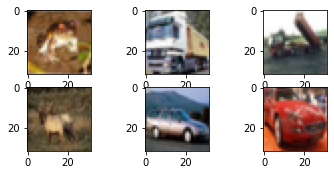

Augmented Images:


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:524: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:530: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:532: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


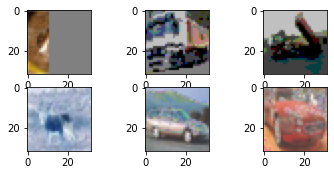

In [10]:
# Display sample images before and after RandAugment
print("Original images:")
for i in range(6):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_x[i])
plt.show()

print("Augmented Images:")
for i in range(6):
    cifar_RA = distort_image_with_randaugment(train_x[i], 2, 5)
    sess = tf.Session()
    with sess.as_default():
        cifar_RA_np = cifar_RA.eval()
    pil_img = Image.fromarray(cifar_RA_np)

    plt.subplot(330 + 1 + i)
    plt.imshow(pil_img)
plt.show()

#### Dataset Generation

In [18]:
# Download the datasets held in S3

bucket = 'sagemaker-june29'
s3path = 'sagemaker/RandAugmentation/'
    
def download_dataset(s3bucket, s3path, file, label):
    label_filename = s3path + label
    image_filename = s3path + file 
    
    s3 = boto3.resource('s3')
    obj = s3.Object(s3bucket, label_filename)
    with io.BytesIO(obj.get()["Body"].read()) as f:
        f.seek(0)
        labels = np.load(f)
        y = labels.astype('long')
            
    obj = s3.Object(s3bucket, image_filename)
    with io.BytesIO(obj.get()["Body"].read()) as f:
        f.seek(0)
        X = np.load(f)
        
    return X,y

test_x, train_x = download_dataset(bucket, 'sagemaker/cifar101/', 'cifar10.1_v6_data.npy', 'cifar10.1_v6_labels.npy')
len(test_x)


2000

In [21]:
rand_aug_testds(1,20,test_x,'cifar10')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:524: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:530: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:532: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()


In [ ]:
#rand_aug_testds(2,20,test_x,'cifar10')

In [ ]:
#rand_aug_testds(3,20,test_x,'cifar10')

In [ ]:
#rand_aug_testds(2,5,test_x,'cifar10')

#### Aggregate Mini-Batch Datasets

In [22]:
# Set the filepath where the mini-NPY files are stored
filepath = "/home/ec2-user/SageMaker"

# Create a list of all mini-NPY files
os.chdir(filepath)
filelist = []
for file in glob.glob("*.npy"):
    filelist.append(file)
    
# Sort the filelist based on the numeric extension
filelist = sorted(filelist,key=lambda x: int(os.path.splitext(x)[0].split('_')[-1]))

# Determine filename for concatenated data based on smaller filename
s = "_"
all_data_filename = s.join(os.path.splitext(filelist[0])[0].split(s)[:-1]) + ".npy"
all_data_filepath = filepath + "/" + all_data_filename
print("Will write aggregated data to:", all_data_filepath)

Will write aggregated data to: /home/ec2-user/SageMaker/cifar10_ra_1_20.npy


In [23]:
# Stack all of the smaller NPY files
os.chdir(filepath)
all_arrays = np.load(os.path.join(filepath, filelist[0]))

for npfile in filelist[1:]:
    all_arrays = np.vstack((all_arrays, (np.load(os.path.join(filepath, npfile)))))

# Save the stacked NPY file 
np.save(all_data_filepath, all_arrays)

#### Calculate the Mean and StdDev for the New Training Dataset

In [27]:
from tqdm.notebook import tqdm
from time import time
from sklearn.preprocessing import normalize

N_CHANNELS = 3

new_dataset = np.load(all_data_filepath)

before = time()
mean = np.zeros(N_CHANNELS)
std = np.zeros(N_CHANNELS)

print('==> Computing mean and std..')
for inputs in new_dataset:
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,:,i].mean()
        std[i] += inputs[:,:,i].std()

dataset_mean = np.true_divide(mean, len(new_dataset))
dataset_std = np.true_divide(std, len(new_dataset))

print("Dataset Mean:", dataset_mean)
#print("  -> Normalized Dataset Mean:", dataset_mean / np.linalg.norm(dataset_mean))
print("  -> Normalized Dataset Mean:", dataset_mean / 255)
print("Dataset STD", dataset_std)
#print("  -> Normalized Dataset STD:", dataset_std / np.linalg.norm(dataset_std))
print("  -> Normalized Dataset STD:", dataset_std / 255)

print("time elapsed: ", time()-before)

==> Computing mean and std..
Dataset Mean: [147.74579687 144.97787402 140.51140332]
  -> Normalized Dataset Mean: [0.57939528 0.56854068 0.55102511]
Dataset STD [43.35525162 42.6019848  43.33842664]
  -> Normalized Dataset STD: [0.17002059 0.16706661 0.16995461]
time elapsed:  0.13925528526306152


#### Write Consolidate File to S3

In [28]:
# Upload the NPY file to S3
bucket='sagemaker-may29'
prefix = 'sagemaker/RandAugmentation/'
path = '/home/ec2-user/SageMaker/'

s3_resource = boto3.resource("s3", region_name="us-east-2")
my_bucket = s3_resource.Bucket(bucket)
my_bucket.upload_file(all_data_filepath, prefix + all_data_filename)